<a href="https://colab.research.google.com/github/Akhilvodnala001/PredictionOfLifeSpanOfMotor/blob/main/LifeSpanOfMotor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
file_path = "/content/anomaly_predictions1.csv"
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Rename incorrect column name
df.rename(columns={"temparature": "temperature"}, inplace=True)

# Encode categorical columns if they exist
label_encoders = {}
categorical_columns = ["status", "anomaly"]  # Columns with categorical values

for col in categorical_columns:
    if col in df.columns:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])  # Convert 'Normal' → 0, 'Anomalous' → 1

# Define feature set
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly"]  # Including encoded 'anomaly'
features = [col for col in features if col in df.columns]  # Select only available columns

# Simulate Remaining Useful Life (RUL) target if missing
if "motor_life_remaining" not in df.columns:
    df["motor_life_remaining"] = np.abs(np.random.normal(loc=500, scale=100, size=len(df)))  # Random life hours

# Drop missing values
df = df.dropna()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df[features], df["motor_life_remaining"], test_size=0.2, random_state=42)

# Train the Random Forest Model
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔹RandomForest Model Performance:\n MAE: {mae:.2f}\n R² Score: {r2:.2f}")

# Example Input Data (For Prediction)
new_data_dict = {
    "voltage": [260] if "voltage" in features else None,
    "current": [5.5] if "current" in features else None,
    "power": [1200] if "power" in features else None,
    "frequency": [50] if "frequency" in features else None,
    "temperature": [75] if "temperature" in features else None,
    "speed": [1800] if "speed" in features else None,
    "anomaly": [1] if "anomaly" in features else None  # 'Anomalous' = 1
}

# Remove None values and convert to DataFrame
new_data = {key: value for key, value in new_data_dict.items() if value is not None}
new_data_df = pd.DataFrame(new_data)

# Predict motor life for the new condition
predicted_life = model.predict(new_data_df)
print(f"🔹 Predicted Motor Life Remaining (in hours): {predicted_life[0]:.2f}")


🔹RandomForest Model Performance:
 MAE: 86.51
 R² Score: -0.07
🔹 Predicted Motor Life Remaining (in hours): 540.66


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
data = pd.read_csv('/content/anomaly_predictions1.csv')

# Convert timestamp to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Rename incorrect column name
data.rename(columns={"temparature": "temperature"}, inplace=True)

# Encode categorical columns
label_encoders = {}
categorical_columns = ["status", "anomaly"]
for col in categorical_columns:
    if col in data.columns:
        label_encoders[col] = LabelEncoder()
        data[col] = label_encoders[col].fit_transform(data[col])

# Feature Engineering
data['voltage_deviation'] = abs(data['voltage'] - data['voltage'].mean())  # Deviation from mean voltage
data['rolling_temp'] = data['temperature'].rolling(window=5, min_periods=1).mean()  # Rolling avg temp

# Select relevant features
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "voltage_deviation", "rolling_temp"]
features = [col for col in features if col in data.columns]

# ✅ Ensure "motor_life_remaining" is calculated consistently
if "motor_life_remaining" not in data.columns:
    data["motor_life_remaining"] = 10000 - (data["voltage"] * 10 + data["current"] * 50)  # Consistent formula

# Drop missing values
data = data.dropna()

# Define input and target variables
X = data[features]
y = data["motor_life_remaining"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n🔹XGBoost Model Performance:")
print(f" MAE: {mae:.2f}")
print(f" R² Score: {r2:.2f}")

# Example Input Data (For Prediction)
new_data_dict = {
    "voltage": [260] if "voltage" in features else None,
    "current": [5.5] if "current" in features else None,
    "power": [1200] if "power" in features else None,
    "frequency": [50] if "frequency" in features else None,
    "temperature": [75] if "temperature" in features else None,
    "speed": [1800] if "speed" in features else None,
    "anomaly": [1] if "anomaly" in features else None,
    "voltage_deviation": [abs(260 - data["voltage"].mean())] if "voltage_deviation" in features else None,
    "rolling_temp": [75] if "rolling_temp" in features else None
}

# Remove None values and convert to DataFrame
new_data = {key: value for key, value in new_data_dict.items() if value is not None}
new_data_df = pd.DataFrame(new_data)

# Predict motor life for the new condition
predicted_life = xgb_model.predict(new_data_df)
print(f"🔹 Predicted Motor Life Remaining (in hours): {predicted_life[0]:.2f}")



🔹XGBoost Model Performance:
 MAE: 8.39
 R² Score: 0.95
🔹 Predicted Motor Life Remaining (in hours): 7343.33


In [ ]:
pip install --upgrade numpy scipy scikit-learn lightgbm catboost


  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [ ]:
!pip uninstall numpy scipy scikit-learn lightgbm catboost -y
!pip install numpy scipy scikit-learn lightgbm catboost


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
  Using cached catboost-1.

In [ ]:
!pip uninstall numpy scipy scikit-learn lightgbm catboost -y
!pip install --upgrade numpy scipy scikit-learn lightgbm catboost


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
  Using cached catboost-1.

In [ ]:
import numpy
import scipy
import sklearn
import lightgbm
import catboost

print("NumPy Version:", numpy.__version__)
print("SciPy Version:", scipy.__version__)
print("Scikit-Learn Version:", sklearn.__version__)
print("LightGBM Version:", lightgbm.__version__)
print("CatBoost Version:", catboost.__version__)


NumPy Version: 1.26.4
SciPy Version: 1.15.2
Scikit-Learn Version: 1.6.1
LightGBM Version: 4.6.0
CatBoost Version: 1.2.7


In [ ]:
model = LGBMRegressor(
    n_estimators=1000,      # More trees for better learning
    learning_rate=0.03,     # Reduce learning rate for stability
    max_depth=15,           # Allow deeper trees
    num_leaves=31,          # Increase leaf nodes for better decision-making
    subsample=0.8,          # Use 80% of data per tree to prevent overfitting
    colsample_bytree=0.8,   # Use 80% of features per tree
    reg_alpha=0.1,          # L1 regularization to avoid overfitting
    reg_lambda=0.1,         # L2 regularization
    random_state=42
)


Generating the Data using SMOTE Below...

In [ ]:
pip install smogn


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load dataset
df = pd.read_csv("/content/anomaly_predictions1.csv")

# Convert timestamp column to datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Ensure data is sorted by timestamp
df = df.sort_values(by="timestamp").reset_index(drop=True)

# Rename incorrect column name
df.rename(columns={"temparature": "temperature"}, inplace=True)

# Drop missing values
df.dropna(inplace=True)

# Encode categorical columns (e.g., "status", "anomaly")
label_encoders = {}
categorical_columns = ["status", "anomaly"]
for col in categorical_columns:
    if col in df.columns:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

# Define load levels based on power consumption
def categorize_load(power, df):
    if power < df["power"].quantile(0.2):
        return "No-load"
    elif power > df["power"].quantile(0.8):
        return "Full-load"
    elif power > df["power"].quantile(0.6):
        return "75%-load"
    elif power > df["power"].quantile(0.4):
        return "50%-load"
    elif power > df["power"].quantile(0.2):
        return "25%-load"
    else:
        return "Unknown"

df["load_level"] = df["power"].apply(lambda x: categorize_load(x, df))

# Remove "Unknown" load levels
df = df[df["load_level"] != "Unknown"]

# Encode load levels as numeric values
label_encoder = LabelEncoder()
df["load_level_encoded"] = label_encoder.fit_transform(df["load_level"])

# Define features and target
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "status"]
target = "load_level_encoded"

# Apply SMOTE for balancing
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(df[features], df[target])

# Convert back to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=features)
df_resampled["load_level_encoded"] = y_resampled

# Convert numeric values back to categorical labels
df_resampled["load_level"] = label_encoder.inverse_transform(df_resampled["load_level_encoded"])

# Generate timestamps strictly within 1 PM to 4 PM
start_date = df["timestamp"].min().date()  # Start from first date in original data
timestamps = []
current_time = pd.Timestamp(start_date) + pd.Timedelta(hours=13)  # Start at 1 PM

for _ in range(len(df_resampled)):
    timestamps.append(current_time)
    current_time += pd.Timedelta(minutes=1)  # Increment by 1 minute

    # Reset time when exceeding 4 PM
    if current_time.hour >= 16:
        current_time = current_time.normalize() + pd.Timedelta(days=1, hours=13)  # Next day at 1 PM

df_resampled["timestamp"] = timestamps

# Save the updated dataset
df_resampled.to_csv("NewData.csv", index=False)
print("NewData.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/anomaly_predictions1.csv'

Prediction of motor lifespan with Load levels is below...

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
file_path = "/content/NewData.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Rename incorrect column name if exists
df.rename(columns={"temparature": "temperature"}, inplace=True)

# Encode categorical columns: 'status', 'anomaly', and 'load_level'
label_encoders = {}
categorical_columns = ["status", "anomaly", "load_level"]  # Add 'load_level' for encoding

for col in categorical_columns:
    if col in df.columns:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])  # Convert categorical to numeric

# Define feature set (now including 'load_level')
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "load_level"]
features = [col for col in features if col in df.columns]  # Ensure all columns exist in the dataset

# Simulate Remaining Useful Life (RUL) target if missing
if "motor_life_remaining" not in df.columns:
    df["motor_life_remaining"] = np.abs(np.random.normal(loc=500, scale=100, size=len(df)))  # Random life hours

# Drop missing values
df = df.dropna()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df[features], df["motor_life_remaining"], test_size=0.2, random_state=42)

# Train the Random Forest Model
model = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔹 RandomForest Model Performance:\n MAE: {mae:.2f}\n R² Score: {r2:.2f}")

# Example Input Data (For Prediction)
new_data_dict = {
    "voltage": [260] if "voltage" in features else None,
    "current": [5.5] if "current" in features else None,
    "power": [1200] if "power" in features else None,
    "frequency": [50] if "frequency" in features else None,
    "temperature": [75] if "temperature" in features else None,
    "speed": [1800] if "speed" in features else None,
    "anomaly": [1] if "anomaly" in features else None,  # 'Anomalous' = 1
    "load_level": [2] if "load_level" in features else None  # Example load level encoding
}

# Convert to DataFrame
new_data = {key: value for key, value in new_data_dict.items() if value is not None}
new_data_df = pd.DataFrame(new_data)

# Predict motor life for the new condition
predicted_life = model.predict(new_data_df)
print(f"🔹 Predicted Motor Life Remaining (in hours): {predicted_life[0]:.2f}")


🔹 RandomForest Model Performance:
 MAE: 75.03
 R² Score: -0.05
🔹 Predicted Motor Life Remaining (in hours): 441.31


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
data = pd.read_csv('/content/NewData.csv')

# Convert timestamp to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Rename incorrect column name
data.rename(columns={"temparature": "temperature"}, inplace=True)

# Encode categorical columns
label_encoders = {}
categorical_columns = ["status", "anomaly", "load_level"]  # Added 'load_level'
for col in categorical_columns:
    if col in data.columns:
        label_encoders[col] = LabelEncoder()
        data[col] = label_encoders[col].fit_transform(data[col])

# Feature Engineering
data['voltage_deviation'] = abs(data['voltage'] - data['voltage'].mean())  # Deviation from mean voltage
data['rolling_temp'] = data['temperature'].rolling(window=5, min_periods=1).mean()  # Rolling avg temp

# Select relevant features
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "load_level", "voltage_deviation", "rolling_temp"]
features = [col for col in features if col in data.columns]

# ✅ Ensure "motor_life_remaining" is calculated consistently
if "motor_life_remaining" not in data.columns:
    data["motor_life_remaining"] = 10000 - (data["voltage"] * 10 + data["current"] * 50 + data["load_level"] * 500)  # Consistent formula with load_level

# Drop missing values
data = data.dropna()

# Define input and target variables
X = data[features]
y = data["motor_life_remaining"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n🔹XGBoost Model Performance:")
print(f" MAE: {mae:.2f}")
print(f" R² Score: {r2:.2f}")

# Example Input Data (For Prediction)
new_data_dict = {
    "voltage": [260] if "voltage" in features else None,
    "current": [5.5] if "current" in features else None,
    "power": [1200] if "power" in features else None,
    "frequency": [50] if "frequency" in features else None,
    "temperature": [75] if "temperature" in features else None,
    "speed": [1800] if "speed" in features else None,
    "anomaly": [1] if "anomaly" in features else None,
    "load_level": [2] if "load_level" in features else None,
    "voltage_deviation": [abs(260 - data["voltage"].mean())] if "voltage_deviation" in features else None,
    "rolling_temp": [75] if "rolling_temp" in features else None
}

# Remove None values and convert to DataFrame
new_data = {key: value for key, value in new_data_dict.items() if value is not None}
new_data_df = pd.DataFrame(new_data)

# Predict motor life for the new condition
predicted_life = xgb_model.predict(new_data_df)
print(f"🔹 Predicted Motor Life Remaining (in hours): {predicted_life[0]:.2f}")



🔹XGBoost Model Performance:
 MAE: 9.82
 R² Score: 1.00
🔹 Predicted Motor Life Remaining (in hours): 6330.46


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = "/content/NewData.csv"
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Rename incorrect column name
df.rename(columns={"temparature": "temperature"}, inplace=True)

# Encode categorical columns
label_encoders = {}
categorical_columns = ["status", "anomaly", "load_level"]  # Added 'load_level'
for col in categorical_columns:
    if col in df.columns:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

# Define feature set
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "load_level"]
features = [col for col in features if col in df.columns]

# ✅ Ensure "motor_life_remaining" is calculated consistently
if "motor_life_remaining" not in df.columns:
    df["motor_life_remaining"] = 10000 - (df["voltage"] * 10 + df["current"] * 50 + df["load_level"] * 500)  # Consider load_level impact

# Drop missing values
df = df.dropna()

# Train-Test Split (with fixed random_state)
X_train, X_test, y_train, y_test = train_test_split(df[features], df["motor_life_remaining"], test_size=0.2, random_state=42)

# Train the LightGBM Model
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=15,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,  # ✅ Fix randomness
    verbose=-1
)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔹 LightGBM Model Performance:\n MAE: {mae:.2f}\n R² Score: {r2:.2f}")

# Example Input Data (For Prediction)
new_data_dict = {
    "voltage": [260] if "voltage" in features else None,
    "current": [5.5] if "current" in features else None,
    "power": [1200] if "power" in features else None,
    "frequency": [50] if "frequency" in features else None,
    "temperature": [75] if "temperature" in features else None,
    "speed": [1800] if "speed" in features else None,
    "anomaly": [1] if "anomaly" in features else None,
    "load_level": [2] if "load_level" in features else None
}

# Remove None values and convert to DataFrame
new_data = {key: value for key, value in new_data_dict.items() if value is not None}
new_data_df = pd.DataFrame(new_data)

# Predict motor life for the new condition
predicted_life = model.predict(new_data_df)
print(f"🔹 Predicted Motor Life Remaining (in hours): {predicted_life[0]:.2f}")


🔹 LightGBM Model Performance:
 MAE: 28.21
 R² Score: 0.97
🔹 Predicted Motor Life Remaining (in hours): 6365.39


<ipython-input-2-daea5cbcfd95>:15: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"])


Random Forest: MAE=86.18, R2=-0.06


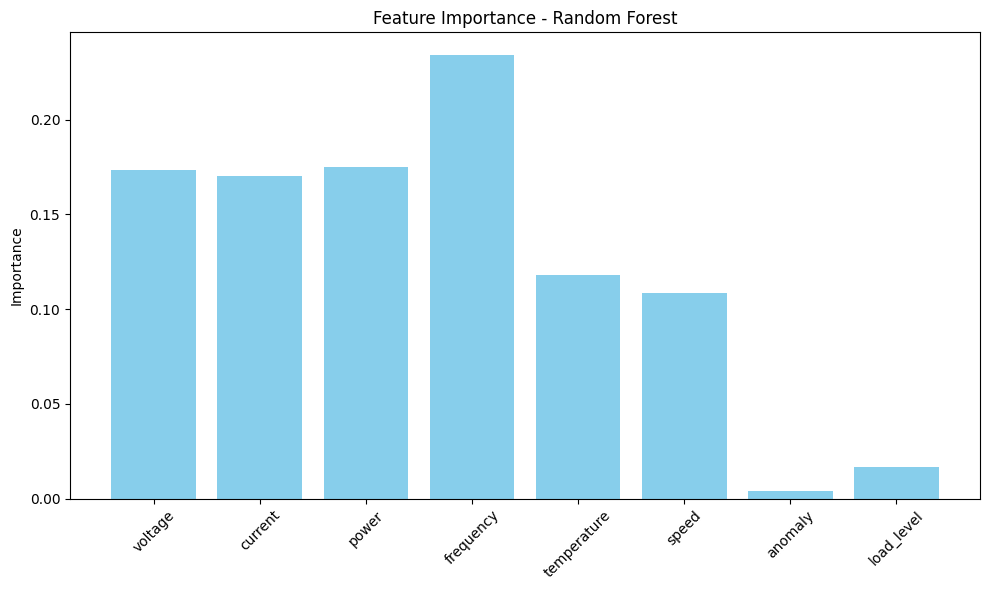

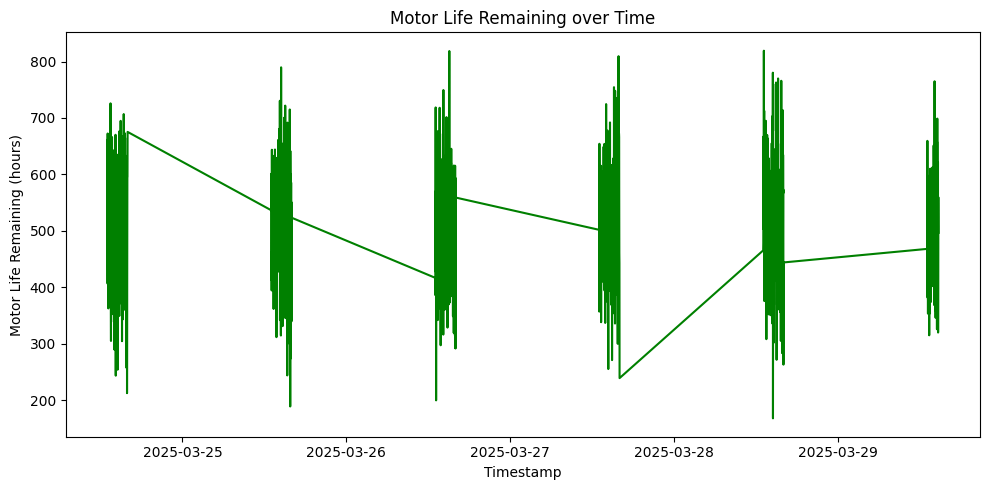


Predicted vs Actual (Random Forest):
        Actual   Predicted
0  607.050351  512.548793
1  550.813800  502.145308
2  478.884177  501.145646
3  479.403011  435.634645
4  418.853821  431.295480


<ipython-input-2-daea5cbcfd95>:78: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['timestamp'] = pd.to_datetime(data['timestamp'])


XGBoost: MAE=9.82, R2=1.00


<Figure size 1000x600 with 0 Axes>

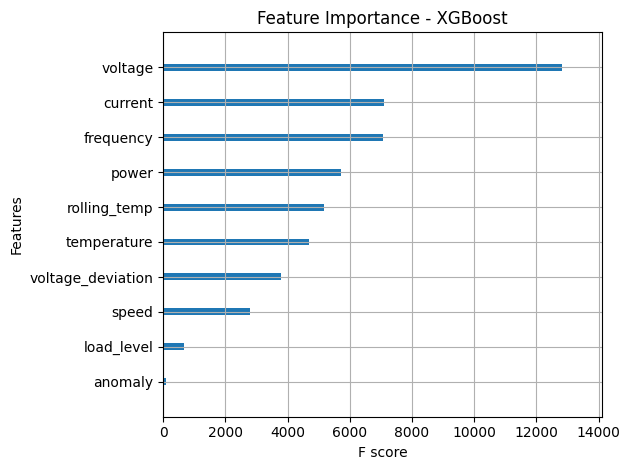

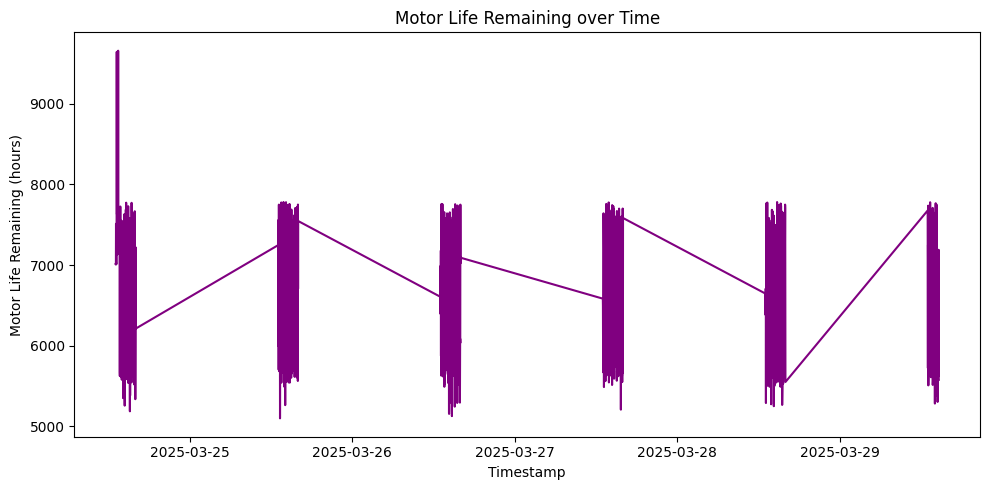


Predicted vs Actual (XGBoost):
         Actual    Predicted
0  6639.733129  6639.175781
1  7193.267731  7188.541016
2  6511.868227  6506.320801
3  5984.705073  5896.785645
4  7169.182602  7163.458008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 8
[LightGBM] [Info] Start training from score 6643.895956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

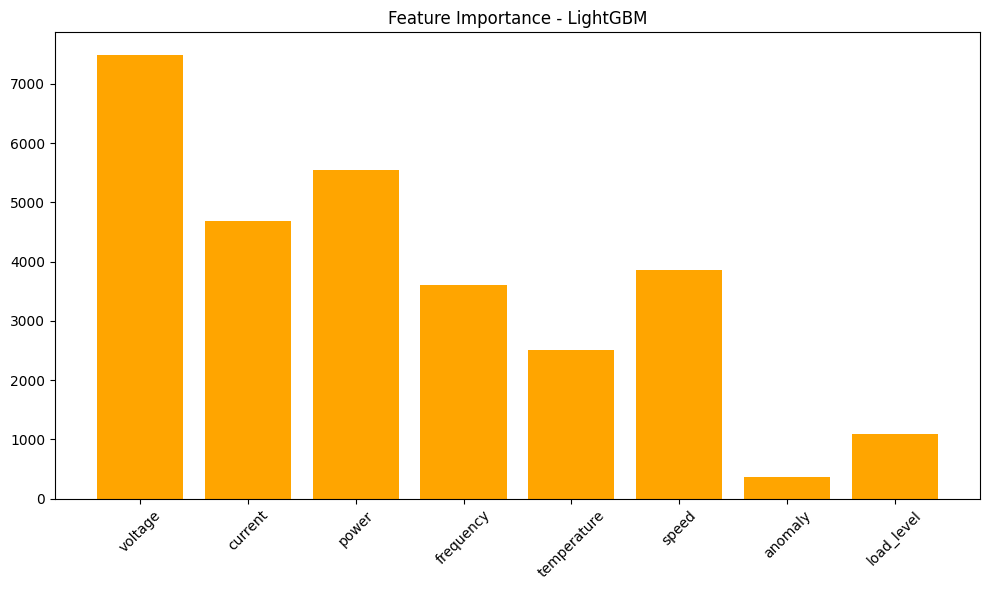

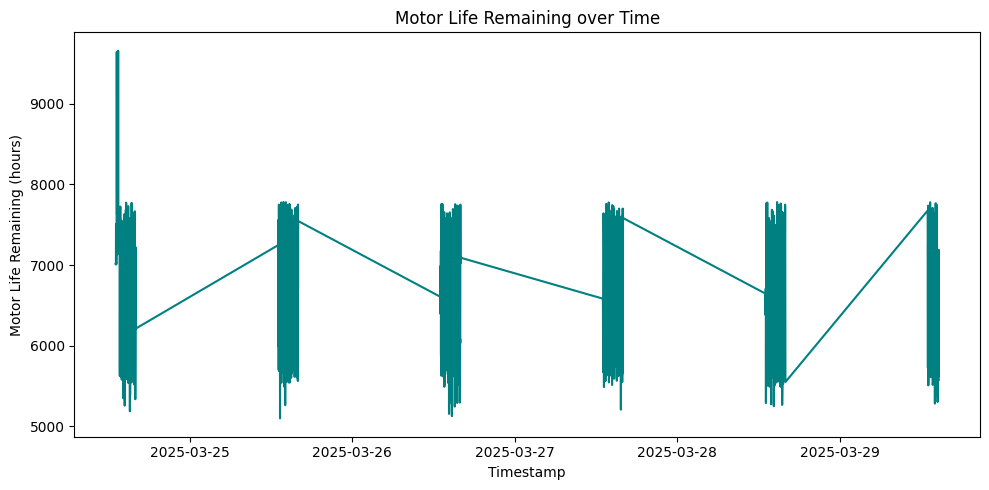


Predicted vs Actual (LightGBM):
         Actual    Predicted
0  6639.733129  6645.527786
1  7193.267731  7186.897057
2  6511.868227  6516.573512
3  5984.705073  5941.423346
4  7169.182602  7213.109050


In [ ]:
# -------------------------
# ✅ CODE 1 with Visualizations (Random Forest)
# -------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
df = pd.read_csv("/content/WithLoadLevel.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.rename(columns={"temparature": "temperature"}, inplace=True)

# Encode categorical columns
label_encoders = {}
categorical_columns = ["status", "anomaly", "load_level"]
for col in categorical_columns:
    if col in df.columns:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

# Feature selection
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "load_level"]
features = [col for col in features if col in df.columns]

# Add RUL column if missing
if "motor_life_remaining" not in df.columns:
    df["motor_life_remaining"] = np.abs(np.random.normal(loc=500, scale=100, size=len(df)))

df = df.dropna()
X_train, X_test, y_train, y_test = train_test_split(df[features], df["motor_life_remaining"], test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest: MAE={mae:.2f}, R2={r2:.2f}")

# --- Visualization A: Feature Importance Bar Chart ---
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(features, importances, color='skyblue')
plt.title("Feature Importance - Random Forest")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Visualization B: Motor Life Remaining vs Time ---
plt.figure(figsize=(10, 5))
plt.plot(df["timestamp"], df["motor_life_remaining"], color='green')
plt.title("Motor Life Remaining over Time")
plt.xlabel("Timestamp")
plt.ylabel("Motor Life Remaining (hours)")
plt.tight_layout()
plt.show()

# --- Visualization C: Predicted vs Actual Table ---
comparison_df = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred})
print("\nPredicted vs Actual (Random Forest):\n", comparison_df.head())


# -------------------------
# ✅ CODE 2 with Visualizations (XGBoost)
# -------------------------

import xgboost as xgb

data = pd.read_csv("/content/WithLoadLevel.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.rename(columns={"temparature": "temperature"}, inplace=True)

label_encoders = {}
categorical_columns = ["status", "anomaly", "load_level"]
for col in categorical_columns:
    if col in data.columns:
        label_encoders[col] = LabelEncoder()
        data[col] = label_encoders[col].fit_transform(data[col])

data['voltage_deviation'] = abs(data['voltage'] - data['voltage'].mean())
data['rolling_temp'] = data['temperature'].rolling(window=5, min_periods=1).mean()
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "load_level", "voltage_deviation", "rolling_temp"]
features = [col for col in features if col in data.columns]

if "motor_life_remaining" not in data.columns:
    data["motor_life_remaining"] = 10000 - (data["voltage"] * 10 + data["current"] * 50 + data["load_level"] * 500)

data = data.dropna()
X = data[features]
y = data["motor_life_remaining"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=10, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"XGBoost: MAE={mae:.2f}, R2={r2:.2f}")

# Visualization A: Feature Importance Bar Chart
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', show_values=False)
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

# Visualization B: Motor Life Remaining vs Time
plt.figure(figsize=(10, 5))
plt.plot(data["timestamp"], data["motor_life_remaining"], color='purple')
plt.title("Motor Life Remaining over Time")
plt.xlabel("Timestamp")
plt.ylabel("Motor Life Remaining (hours)")
plt.tight_layout()
plt.show()

# Visualization C: Predicted vs Actual Table
comparison_df = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred})
print("\nPredicted vs Actual (XGBoost):\n", comparison_df.head())


# -------------------------
# ✅ CODE 3 with Visualizations (LightGBM)
# -------------------------

import warnings
from lightgbm import LGBMRegressor
warnings.filterwarnings("ignore")

df = pd.read_csv("/content/WithLoadLevel.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.rename(columns={"temparature": "temperature"}, inplace=True)

label_encoders = {}
categorical_columns = ["status", "anomaly", "load_level"]
for col in categorical_columns:
    if col in df.columns:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "load_level"]
features = [col for col in features if col in df.columns]

if "motor_life_remaining" not in df.columns:
    df["motor_life_remaining"] = 10000 - (df["voltage"] * 10 + df["current"] * 50 + df["load_level"] * 500)

df = df.dropna()
X_train, X_test, y_train, y_test = train_test_split(df[features], df["motor_life_remaining"], test_size=0.2, random_state=42)

model = LGBMRegressor(n_estimators=1000, learning_rate=0.03, max_depth=15, num_leaves=31, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"LightGBM: MAE={mae:.2f}, R2={r2:.2f}")

# Visualization A: Feature Importance Bar Chart
plt.figure(figsize=(10, 6))
importance = model.feature_importances_
plt.bar(features, importance, color='orange')
plt.title("Feature Importance - LightGBM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization B: Motor Life Remaining vs Time
plt.figure(figsize=(10, 5))
plt.plot(df["timestamp"], df["motor_life_remaining"], color='teal')
plt.title("Motor Life Remaining over Time")
plt.xlabel("Timestamp")
plt.ylabel("Motor Life Remaining (hours)")
plt.tight_layout()
plt.show()

# Visualization C: Predicted vs Actual Table
comparison_df = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred})
print("\nPredicted vs Actual (LightGBM):\n", comparison_df.head())


🔹 RandomForest Model Performance:
 MAE: 93.36
 R² Score: -0.05


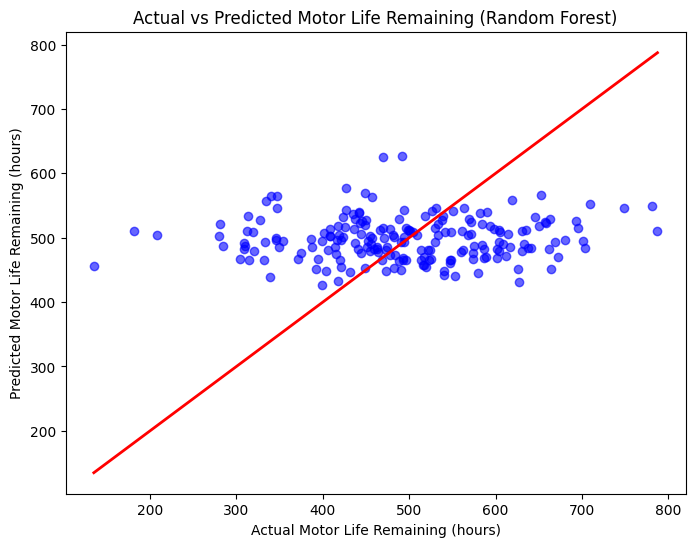

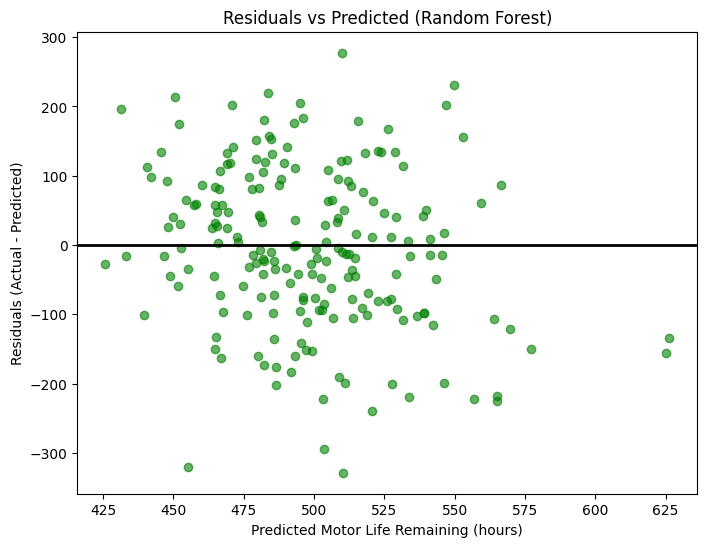

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
file_path = "/content/WithLoadLevel.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Rename incorrect column name if exists
df.rename(columns={"temparature": "temperature"}, inplace=True)

# Encode categorical columns
label_encoders = {}
categorical_columns = ["status", "anomaly", "load_level"]

for col in categorical_columns:
    if col in df.columns:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

# Define feature set
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "load_level"]
features = [col for col in features if col in df.columns]

# Simulate motor life remaining if missing
if "motor_life_remaining" not in df.columns:
    df["motor_life_remaining"] = np.abs(np.random.normal(loc=500, scale=100, size=len(df)))

# Drop missing values
df = df.dropna()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df[features], df["motor_life_remaining"], test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔹 RandomForest Model Performance:\n MAE: {mae:.2f}\n R² Score: {r2:.2f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Ideal line
plt.title("Actual vs Predicted Motor Life Remaining (Random Forest)")
plt.xlabel("Actual Motor Life Remaining (hours)")
plt.ylabel("Predicted Motor Life Remaining (hours)")
plt.show()

# Plot Residuals
plt.figure(figsize=(8, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, color='green', alpha=0.6)
plt.axhline(0, color='black', linewidth=2)
plt.title("Residuals vs Predicted (Random Forest)")
plt.xlabel("Predicted Motor Life Remaining (hours)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()


🔹XGBoost Model Performance:
 MAE: 14.61
 R² Score: 0.99


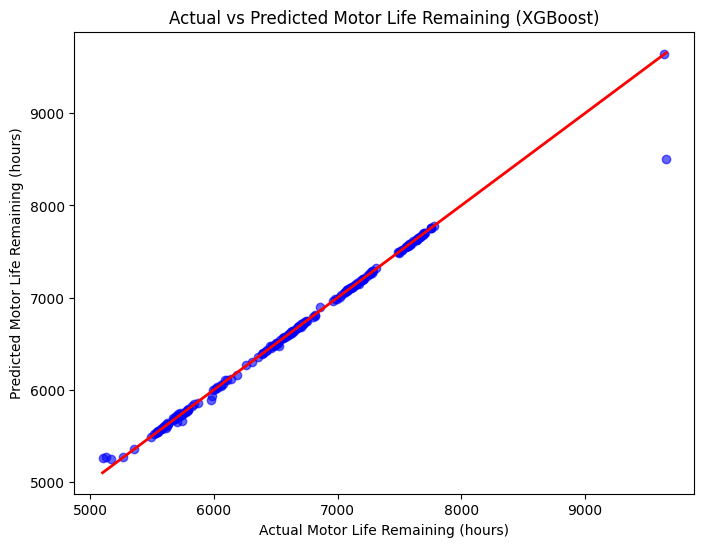

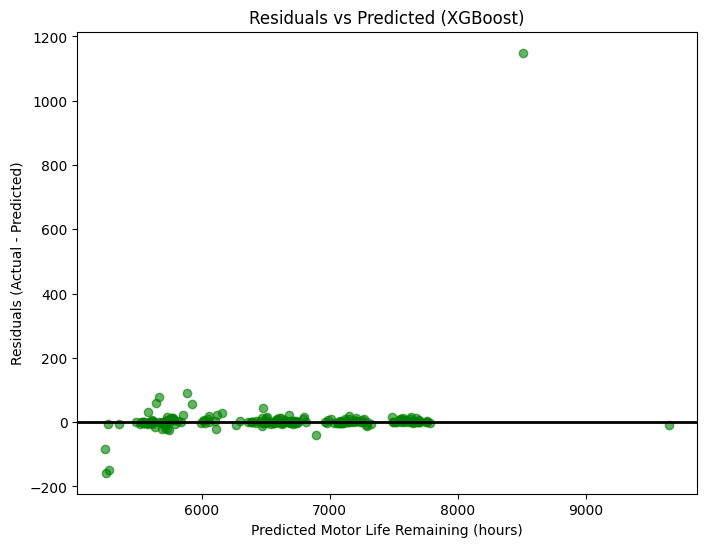

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
data = pd.read_csv('/content/WithLoadLevel.csv')

# Convert timestamp to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Rename incorrect column name
data.rename(columns={"temparature": "temperature"}, inplace=True)

# Encode categorical columns
label_encoders = {}
categorical_columns = ["status", "anomaly", "load_level"]
for col in categorical_columns:
    if col in data.columns:
        label_encoders[col] = LabelEncoder()
        data[col] = label_encoders[col].fit_transform(data[col])

# Feature Engineering
data['voltage_deviation'] = abs(data['voltage'] - data['voltage'].mean())  # Deviation from mean voltage
data['rolling_temp'] = data['temperature'].rolling(window=5, min_periods=1).mean()  # Rolling avg temp

# Define features
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "load_level", "voltage_deviation", "rolling_temp"]
features = [col for col in features if col in data.columns]

# Ensure "motor_life_remaining" is calculated
if "motor_life_remaining" not in data.columns:
    data["motor_life_remaining"] = 10000 - (data["voltage"] * 10 + data["current"] * 50 + data["load_level"] * 500)

# Drop missing values
data = data.dropna()

# Define input and target variables
X = data[features]
y = data["motor_life_remaining"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=10, subsample=0.8, colsample_bytree=0.8, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔹XGBoost Model Performance:\n MAE: {mae:.2f}\n R² Score: {r2:.2f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Ideal line
plt.title("Actual vs Predicted Motor Life Remaining (XGBoost)")
plt.xlabel("Actual Motor Life Remaining (hours)")
plt.ylabel("Predicted Motor Life Remaining (hours)")
plt.show()

# Plot Residuals
plt.figure(figsize=(8, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, color='green', alpha=0.6)
plt.axhline(0, color='black', linewidth=2)
plt.title("Residuals vs Predicted (XGBoost)")
plt.xlabel("Predicted Motor Life Remaining (hours)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 8
[LightGBM] [Info] Start training from score 6643.895956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

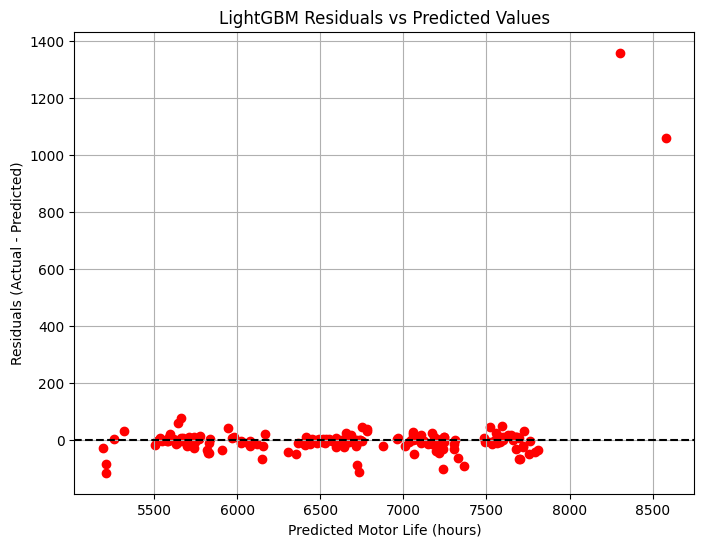

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score

warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("/content/WithLoadLevel.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.rename(columns={"temparature": "temperature"}, inplace=True)

# Encode categorical columns
categorical_columns = ["status", "anomaly", "load_level"]
for col in categorical_columns:
    if col in df.columns:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])

# Define feature columns
features = ["voltage", "current", "power", "frequency", "temperature", "speed", "anomaly", "load_level"]
features = [col for col in features if col in df.columns]

# Generate target column if not present
if "motor_life_remaining" not in df.columns:
    df["motor_life_remaining"] = 10000 - (df["voltage"] * 10 + df["current"] * 50 + df["load_level"] * 500)

# Clean data
df.dropna(inplace=True)

# Train-test split
X = df[features]
y = df["motor_life_remaining"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = LGBMRegressor(n_estimators=1000, learning_rate=0.03, max_depth=15,
                      subsample=0.8, colsample_bytree=0.8, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔹 LightGBM Model Performance:")
print(f"   MAE: {mae:.2f}")
print(f"   R² Score: {r2:.2f}\n")

# Print actual vs predicted
comparison_df = pd.DataFrame({
    "Actual Life (hours)": y_test.values,
    "Predicted Life (hours)": y_pred
})
print("🔍 Sample Predictions:\n", comparison_df.head(10))

# Visualization: Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Predicted Motor Life (hours)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("LightGBM Residuals vs Predicted Values")
plt.grid(True)
plt.show()
